# Fashion MNIST Classification
- with a linear network
- https://github.com/zalandoresearch/fashion-mnist
    - 60000 training, 10000 test
    - $28\times28$ grayscale
    - Highest test accuracy: 0.939 by Google AutoML, 24 compute hours
- https://github.com/dsgiitr/d2l-pytorch/tree/master/Ch05_Linear_Neural_Networks

## Getting the Data

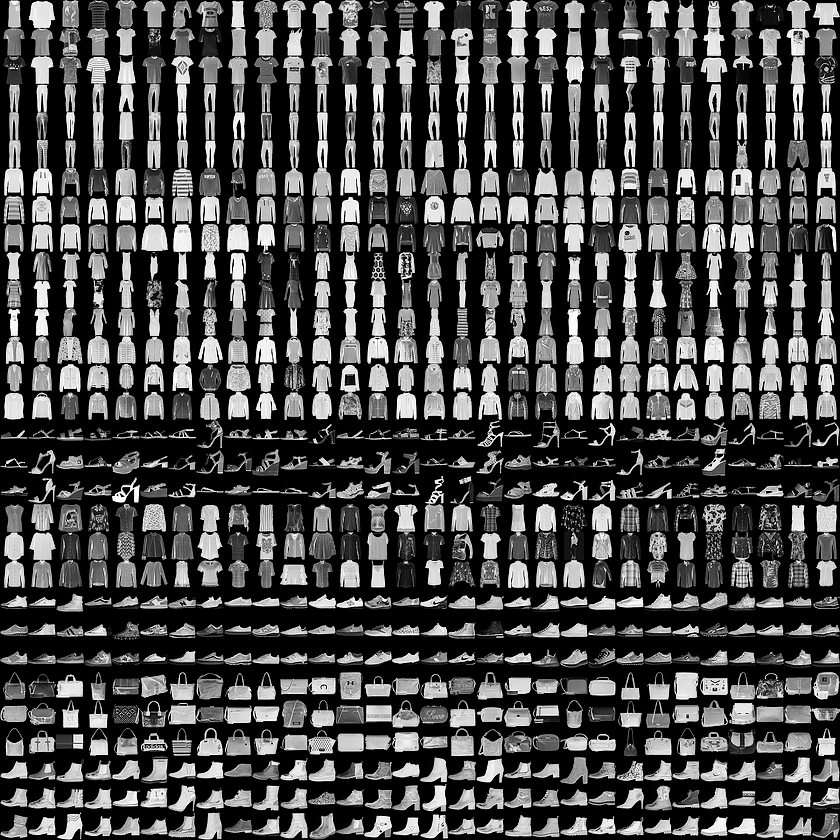

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import time

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
dataset = {'train': torchvision.datasets.FashionMNIST('../data', train=True, download=True),
              'val' : torchvision.datasets.FashionMNIST('../data', train=False, download=True) }

### torchvision datasets are of type PIL

In [4]:
im, label = dataset['train'][0]
im, label

(<PIL.Image.Image image mode=L size=28x28 at 0x1364C212588>, 9)

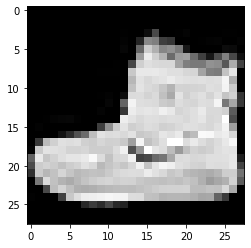

In [5]:
plt.imshow(im, cmap='gray')

### PIL to tensor

In [6]:
xforms = transforms.Compose([transforms.ToTensor()])
dataset = {'train': torchvision.datasets.FashionMNIST('../data', train=True, download=True, transform=xforms),
           'val' : torchvision.datasets.FashionMNIST('../data', train=False, download=True, transform=xforms) }

fashion_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

print([(k, len(dataset[k])) for k in dataset.keys()])

[('train', 60000), ('val', 10000)]


### now the return data is torch.tensor, float32

In [7]:
im, label = dataset['train'][0]

im.dtype, im.shape, label, type(label)

(torch.float32, torch.Size([1, 28, 28]), 9, int)

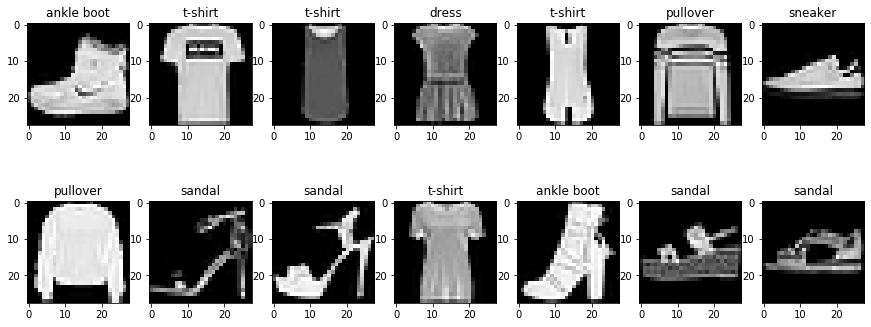

In [8]:
fig, axes = plt.subplots(2,7, figsize=(15,6))
for i, ax in enumerate(axes.reshape(-1)):
    im, label = dataset['train'][i]
    ax.imshow(im.reshape(28,28), cmap='gray')
    ax.set_title(fashion_labels[label])


## Dataloaders

In [9]:
dataset.keys()

dict_keys(['train', 'val'])

In [10]:
#
def get_data_loader(batch_size):
    data_loader = { tv: torch.utils.data.DataLoader(dataset[tv], batch_size=batch_size, shuffle=True)
                   for tv in dataset.keys()}
    return data_loader

batch_size = 8
data_loader = get_data_loader(batch_size)

## Network Model & Loss Function

In [11]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 784) # (Batch, Features)
#

# A very simple model
def myNNModel(option=1):
    n_targets = 10
    in_ft = 784
    if option == 1:
        model = nn.Sequential(Reshape(),
                              nn.Linear(in_features=784, out_features=10) )
    elif option == 2:
        in_ft = 784
        model = nn.Sequential(Reshape(),
                              nn.Linear(in_features=in_ft, out_features=in_ft//2),
                              nn.Tanh(),
                              nn.Linear(in_ft//2, n_targets))
    return model
#
loss_fn = nn.CrossEntropyLoss()

### About CrossEntropyLoss() & Soft-Max 
- Suppose we give a data $x$ of class $k$. The model outputs 10 dimensional score vector  $s$.
- Softmax is the next procedure to be applied to the score vector to produce predicted class probabilities $q$:
$$
    \begin{align}
        q_i & = {e^{s_i}}\big/{\sum_j e^{s_j}} \\
            & = \mbox{softmax(s, label=i)}
    \end{align}
$$

- Loss function is chosen to be cross entropy, as all the other classification problems:
$$
    H(p, q) = -\sum_i p_i \log q_i
$$
    - $H(p,q)$ has minimum when $q == p$. 
    - In our case, $p$ is fixed and $q$ is a function parameterized by the weights of the layers.
    
- Here we have model probability $p=OneHot(k)$ which has 0s at all the locations but 1 at the $k$th location.   It does not have to be OneHot vector as a probability density model. If an input may be categorized to two objects at the same time, $p=[0,... 1/2, ..., 1/2, ... 0]$.

$$ p=OneHot(k) = [0, ... 1 ... 0] 
$$
    
- Therefore, the cross-entropy for this particular case is

$$
    \begin{align}
        H(p, q)  & =  - p_k \log q_k \\
                 & =  - \log q_k     \\
                 & =  - \log\big( {e^{s_k}}/{\sum_j e^{s_j}} \big) \\
                 & = -\bigg(s_k - \log\big(\sum_j e^{s_j}\big) \bigg)
    \end{align}
$$

- Numerical computation of this formula is much more stable than computing $\log(\exp(s_k))$ step by step.
- Given a score vector, pytorch `nn.CrossEntropyLoss()` computes this loss.
- That is, `nn.CrossEntropyLoss()` = `NLLLoss(LogSoftMax())`

* Why Cross Entropy?
    - $H(p, q)$ has a minimum value when $q$ is equal to $p$.
    - When $p==q$
$$
            H(p,p) = -\sum_i p_i \log p_i = \sum_i p_i \log\frac{1}{p_i}
$$
        - $1/p_i$ is called information. 
        - $H(p,p)$ is called the entropy of the probability density $p$.
    - One may imagine a quantity normalized by $H(p,p)$:
    $$
            D(p,q) = H(p,q) - H(p,p)
    $$

---
### Cross Entropy & Maximum Likelihood Estimate

- The probability mass function $q_i=P(C=i|x)$, i=0...9, of being class $i$ given an input $x$ is computed through a neural network model.
- Given this probatility mass $q=[q_i]$, what is the data likelihood?
    - In the case of Gaussian distribution modeling, the output of neural network model is the mean $\mu(x)$ and std $\sigma(x)$ given $x$. 
        - The likelihood is given by
    $$
        \begin{align}
        L & = Prob( y - \delta < y < y + \delta | x) \\
          & = \delta \cdot \cal{N}(x| \mu(x), \sigma(x)) \\
          & = \exp\bigg\{ -0.5 (y - \mu(x))^2 / \sigma(x)^2 \bigg\} \big/ \sqrt{2\pi}\sigma(x)
        \end{align}
    $$
        - This is used for regression problems. Linear regression must be the easiest case.
        - $L$ is actually the probability of $y$ being in the interval $[y-\delta, y+\delta]$.
        - $L$ is called the likelihood of $y$ when $L$ is regarded as a function of $\mu$ and $\sigma$. 
            - The likelihood of $y$ can be increased or decreased by changing the values of $\mu$ and/or $\sigma$.
        
    - In case of Bernoulli distribution, a discrete distribution, there are only two events {0, 1}. 
        - Given a probability $p$ given by a NN model $p(x)$, when the target label is $y=1$ the likelihood is 
        $$
            L = Prob(y = 1 | x) = p = p(x, w)
        $$
        Otherwise, when $y=0$
        $$
            L = Prob(y = 0 | x) = 1 - p = 1 - p(x, w)
        $$
    
    - In the case of [Categorical or Multinoulli distribution](https://en.wikipedia.org/wiki/Categorical_distribution), that is when we have 10 events, we have $C=10$ candidates and $K$ discrete probabilities $\{p_i, i=1,...,K \}$, $\sum_{i=1}^K p_i = 1$
    
        - Since we are trying to make a model that predicts the probability, given a data $(x, k)$, $k$ being a GT label, we have a predicted probability vector $q_i = \mbox{NN}(x; w) \in \mathbb{R}^{10}$. It is an estimate of true $p_i$, The likelihood is 
    $$
        \begin{align}
            L   & = Prob(label = k | x) = q_k \\
                & = \mbox{ the $k$-th output from SoftMax() }
        \end{align}
    $$
    and we want to maximize $L$, the class probability, by modifying $w$, the parameters of NN.
    - For numerical stability mostly, we may instead maximize its logarithmic version
    $$
        l = l(w) = \log q_k(x, w)
    $$
    - The numerical package in PyTorch does only minimization. So we minimize the negative of the log-likelihood:
    $$
        \begin{align}
            NLL(w) & = -l(w) \\
                    & = -\log q_k(x, w) \\
                    & = - \log\big(\mbox{SoftMax}(s_k(x,w))\big)
        \end{align}
    $$
    

---
### Cross Entropy & Kullback-Leibler divergence
- KL Divergence
$$
    D_\mathrm{K}(p||q) = H(p,q) - H(p,p)
$$
- Cross Entropy
$$
    H(p,q) = - \sum_i p_i \log q_i
$$
- Information Entropy (Average Information)
$$
    \begin{align}
        H(p,p) = H(p) & = - \sum_i p_i \log p_i \\
        & = \sum_i p_i \log \frac{1}{p_i}
    \end{align}
$$
- Information
$$
    I(p_i) = \log\frac{1}{p_i} = I(x_i)
$$
where $x_i$ is a particular outcome of a random variable $X$.
    - Expection of $I(x_i)$ is defined to be $H(p)$ or denoted to be $H(X)$
    $$
        \mathbb{E}(I(x_i)) = H(p) = H(X)
    $$
    
- Minimizing the KL Divergence w.r.t $q$ is equivalent to minimizing the Cross Entropy w.r.t $q$. Why?


#### References
- https://en.wikipedia.org/wiki/Entropy_(information_theory)
- https://en.wikipedia.org/wiki/Cross_entropy
- https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence
- http://www.inference.org.uk/mackay/itprnn/book.html
- https://www.microsoft.com/en-us/research/people/cmbishop/
- https://www.cs.ubc.ca/~murphyk/MLbook/

## Training Loop

In [12]:
def training_loop(n_epochs, optim, model, loss_fn, dl_train, dl_val, hist=None, lr_scheduler=None):
    if hist is not None:
        pass
    else:
        hist = {'tloss': [], 'tacc': [], 'vloss': [], 'vacc': []}
    #
    if lr_scheduler is not None:
        lr = []
        
    best_acc = 0
    for epoch in range(1, n_epochs+1):
        tr_loss, tr_acc = 0., 0.
        n_data = 0
        for im_batch, label_batch in dl_train: # minibatch
            im_batch, label_batch = im_batch.to(device), label_batch.to(device)
            ypred = model(im_batch)
            loss_train = loss_fn(ypred, label_batch)
        
            optim.zero_grad()
            loss_train.backward()
            optim.step()
            
            # accumulate correct prediction
            tr_acc  += (torch.argmax(ypred.detach(), dim=1) == label_batch).sum().item() # number of correct predictions
            tr_loss += loss_train.item() * im_batch.shape[0]
            n_data  += im_batch.shape[0]
        # end mini-batch loop
        
        # statistics
        tr_loss /= n_data
        tr_acc  /= n_data
        #
        val_loss, val_acc = performance(model, loss_fn, dl_val)
        
        if epoch <= 5 or epoch % 1000 == 0 or epoch == n_epochs:
             print(f'Epoch {epoch}, tloss {tr_loss:.2f} t_acc: {tr_acc:.2f}  vloss {val_loss:.2f}  v_acc: {val_acc:.2f}')
        
        # best accuracy
        if best_acc < val_acc:
            best_acc = val_acc
            print(f' >> best val accuracy updated: {best_acc} at epoch {epoch}.')
        #
        # record for history return
        if hist is not None:
            hist['tloss'].append(tr_loss)
            hist['vloss'].append(val_loss) 
            hist['tacc'].append(tr_acc)
            hist['vacc'].append(val_acc)
            
        if lr_scheduler is not None:
            lr.append(lr_scheduler.get_lr()) # the lr used in optim.
            lr_scheduler.step()
        # end epoch-loop
        
    if lr_scheduler is not None:
        hist['lr'] = lr
        
    print ('finished training_loop().')
    return hist
#

def performance(model, loss_fn, dataloader):
    model.eval()
    with torch.no_grad():
        loss, acc, n = 0., 0., 0.
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            ypred = model(x)
            loss += loss_fn(ypred, y).item() * len(y)
            p = torch.argmax(ypred, dim=1)
            acc += (p == y).sum().item()
            n += len(y)
        #
    loss /= n
    acc /= n
    return loss, acc
#
def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(16,6))
    axes[0].set_title('Loss'); 
    axes[0].plot(history['tloss'], label='train'); axes[0].plot(history['vloss'], label='val')
    axes[0].legend()
    max_vacc = max(history['vacc'])
    axes[1].set_title(f'Acc. vbest: {max_vacc:.2f}')
    axes[1].plot(history['tacc'], label='train'); axes[1].plot(history['vacc'], label='val')
    axes[1].legend()
#

## Training Setup

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = myNNModel().to(device)
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().to(device)

history = None

cuda


## First Trial

Epoch 1, tloss 8.14 t_acc: 0.77  vloss 8.26  v_acc: 0.78
 >> best val accuracy updated: 0.7795 at epoch 1.
Epoch 2, tloss 8.38 t_acc: 0.80  vloss 8.88  v_acc: 0.80
 >> best val accuracy updated: 0.7985 at epoch 2.
Epoch 3, tloss 8.36 t_acc: 0.80  vloss 13.24  v_acc: 0.75
Epoch 4, tloss 8.47 t_acc: 0.81  vloss 10.21  v_acc: 0.81
 >> best val accuracy updated: 0.8103 at epoch 4.
Epoch 5, tloss 8.34 t_acc: 0.81  vloss 9.45  v_acc: 0.77
 >> best val accuracy updated: 0.8175 at epoch 6.
 >> best val accuracy updated: 0.8191 at epoch 9.
Epoch 10, tloss 8.46 t_acc: 0.81  vloss 9.07  v_acc: 0.81
finished training_loop().
Wall time: 3min 55s


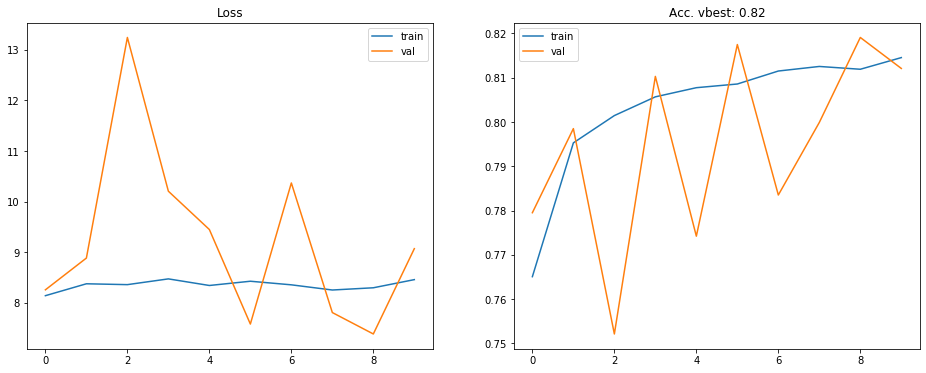

In [14]:
%%time
history = training_loop(10, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
plot_history(history)

## Try to Change Batch Size
- computation speed

In [16]:
data_loader = get_data_loader(batch_size=128)

model = myNNModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().to(device)

history = None

Epoch 1, tloss 1.51 t_acc: 0.77  vloss 1.52  v_acc: 0.76
 >> best val accuracy updated: 0.7603 at epoch 1.
Epoch 2, tloss 1.31 t_acc: 0.80  vloss 1.23  v_acc: 0.80
 >> best val accuracy updated: 0.8016 at epoch 2.
Epoch 3, tloss 1.42 t_acc: 0.81  vloss 1.88  v_acc: 0.79
Epoch 4, tloss 1.43 t_acc: 0.81  vloss 1.43  v_acc: 0.82
 >> best val accuracy updated: 0.8179 at epoch 4.
Epoch 5, tloss 1.47 t_acc: 0.81  vloss 1.53  v_acc: 0.81
 >> best val accuracy updated: 0.8182 at epoch 7.
 >> best val accuracy updated: 0.8278 at epoch 9.
Epoch 10, tloss 1.51 t_acc: 0.82  vloss 2.44  v_acc: 0.79
finished training_loop().
Wall time: 1min 1s


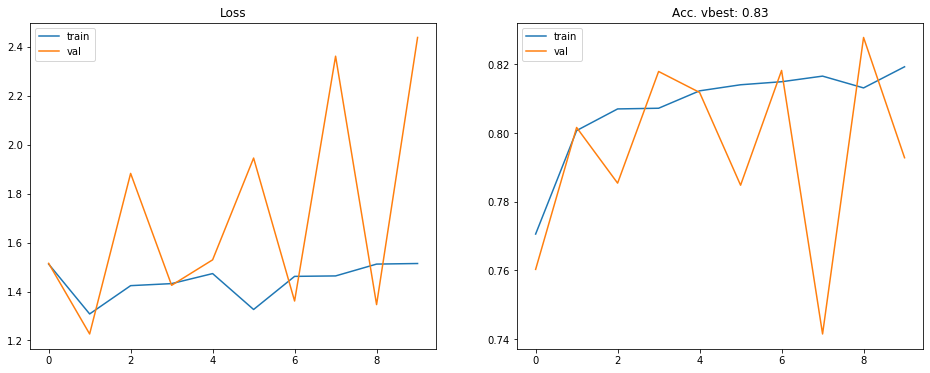

In [17]:
%%time
history = training_loop(10, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        history)
plot_history(history)

## Try More Complex Model with Additional Layers

In [18]:
data_loader = get_data_loader(batch_size=128)

model = myNNModel(option=2).to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().to(device)

history = None

Sequential(
  (0): Reshape()
  (1): Linear(in_features=784, out_features=392, bias=True)
  (2): Tanh()
  (3): Linear(in_features=392, out_features=10, bias=True)
)


Epoch 1, tloss 3.06 t_acc: 0.56  vloss 3.20  v_acc: 0.61
 >> best val accuracy updated: 0.6061 at epoch 1.
Epoch 2, tloss 2.64 t_acc: 0.59  vloss 2.50  v_acc: 0.53
Epoch 3, tloss 2.65 t_acc: 0.60  vloss 3.35  v_acc: 0.68
 >> best val accuracy updated: 0.6796 at epoch 3.
Epoch 4, tloss 2.53 t_acc: 0.62  vloss 2.33  v_acc: 0.69
 >> best val accuracy updated: 0.6881 at epoch 4.
Epoch 5, tloss 3.02 t_acc: 0.61  vloss 3.98  v_acc: 0.52
Epoch 10, tloss 2.89 t_acc: 0.63  vloss 2.73  v_acc: 0.68
finished training_loop().
Wall time: 1min 6s


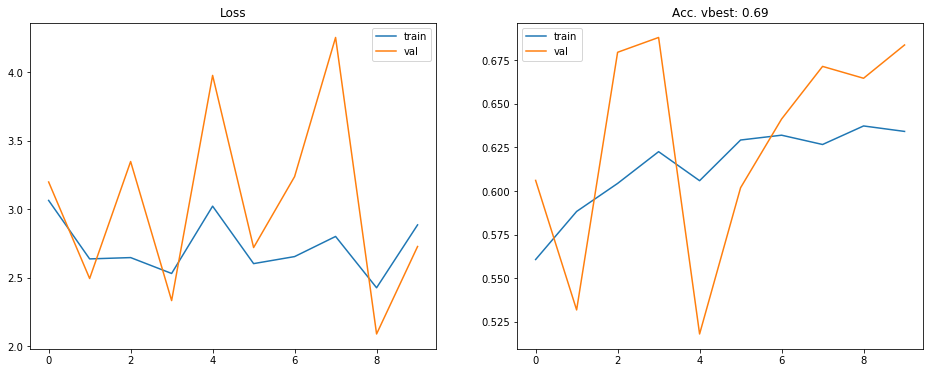

In [19]:
%%time
history = training_loop(10, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        history)
plot_history(history)

## Try SGD and learning_rate

In [20]:
data_loader = get_data_loader(batch_size=128)

model = myNNModel(option=2).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().to(device)

history = None

Epoch 1, tloss 0.67 t_acc: 0.77  vloss 0.52  v_acc: 0.82
 >> best val accuracy updated: 0.8152 at epoch 1.
Epoch 2, tloss 0.48 t_acc: 0.83  vloss 0.55  v_acc: 0.81
Epoch 3, tloss 0.45 t_acc: 0.84  vloss 0.48  v_acc: 0.83
 >> best val accuracy updated: 0.8293 at epoch 3.
Epoch 4, tloss 0.42 t_acc: 0.85  vloss 0.45  v_acc: 0.84
 >> best val accuracy updated: 0.8394 at epoch 4.
Epoch 5, tloss 0.41 t_acc: 0.85  vloss 0.44  v_acc: 0.84
 >> best val accuracy updated: 0.8437 at epoch 5.
 >> best val accuracy updated: 0.8505 at epoch 6.
 >> best val accuracy updated: 0.8515 at epoch 7.
Epoch 10, tloss 0.36 t_acc: 0.87  vloss 0.42  v_acc: 0.85
finished training_loop().
Wall time: 1min 4s


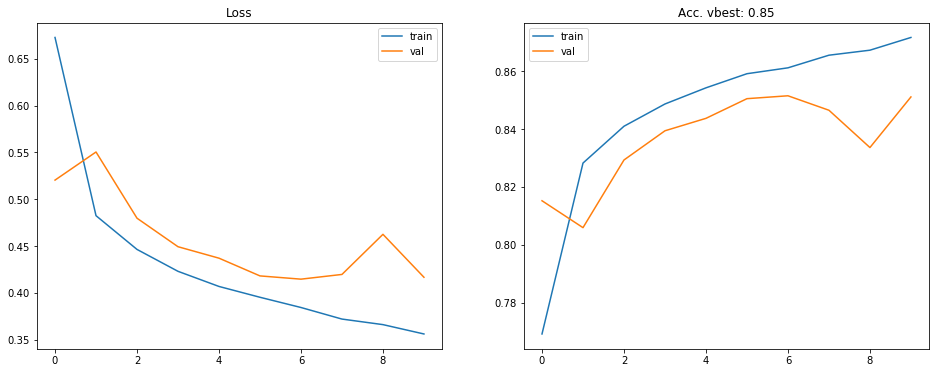

In [21]:
%%time
history = training_loop(10, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        history)
plot_history(history)

#### Additional Training to See More

Epoch 1, tloss 0.35 t_acc: 0.87  vloss 0.39  v_acc: 0.86
 >> best val accuracy updated: 0.86 at epoch 1.
Epoch 2, tloss 0.34 t_acc: 0.88  vloss 0.38  v_acc: 0.87
 >> best val accuracy updated: 0.8652 at epoch 2.
Epoch 3, tloss 0.34 t_acc: 0.88  vloss 0.38  v_acc: 0.86
Epoch 4, tloss 0.34 t_acc: 0.88  vloss 0.38  v_acc: 0.86
Epoch 5, tloss 0.33 t_acc: 0.88  vloss 0.41  v_acc: 0.85
 >> best val accuracy updated: 0.8674 at epoch 8.
 >> best val accuracy updated: 0.8708 at epoch 10.
 >> best val accuracy updated: 0.874 at epoch 12.
 >> best val accuracy updated: 0.8758 at epoch 13.
Epoch 20, tloss 0.27 t_acc: 0.90  vloss 0.35  v_acc: 0.88
 >> best val accuracy updated: 0.8775 at epoch 20.
finished training_loop().
Wall time: 2min 4s


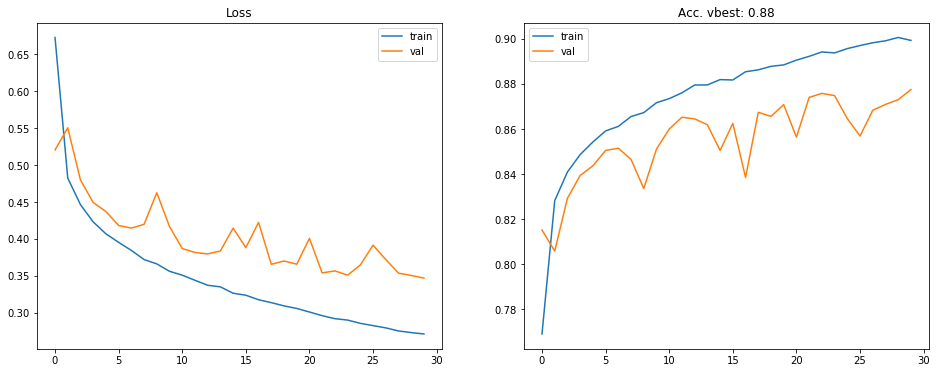

In [22]:
%%time
history = training_loop(20, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        history)
plot_history(history)

## Try Learning Rate Scheduler
- Nice Tutorial: https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/
- Benefits when it is designed well
    - converge faster
    - higher accuracy
- StepLR()
    $$
        \eta_{t} = \eta_{t-1} \gamma
    $$
    where $\gamma$ is the leraning rate.
- Following is just a demonstration

In [23]:
data_loader = get_data_loader(batch_size=128)

model = myNNModel(option=2).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.1  # the same as before at the beginning
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

history = None

Epoch 1, tloss 0.67 t_acc: 0.77  vloss 0.53  v_acc: 0.81
 >> best val accuracy updated: 0.8111 at epoch 1.
Epoch 2, tloss 0.48 t_acc: 0.83  vloss 0.50  v_acc: 0.83
 >> best val accuracy updated: 0.8259 at epoch 2.
Epoch 3, tloss 0.44 t_acc: 0.84  vloss 0.47  v_acc: 0.83
 >> best val accuracy updated: 0.8261 at epoch 3.
Epoch 4, tloss 0.42 t_acc: 0.85  vloss 0.45  v_acc: 0.84
 >> best val accuracy updated: 0.8387 at epoch 4.
Epoch 5, tloss 0.41 t_acc: 0.85  vloss 0.44  v_acc: 0.84
 >> best val accuracy updated: 0.8403 at epoch 5.
 >> best val accuracy updated: 0.8474 at epoch 6.
 >> best val accuracy updated: 0.8505 at epoch 9.
Epoch 10, tloss 0.37 t_acc: 0.87  vloss 0.41  v_acc: 0.85
 >> best val accuracy updated: 0.8511 at epoch 10.
finished training_loop().
Wall time: 1min 2s


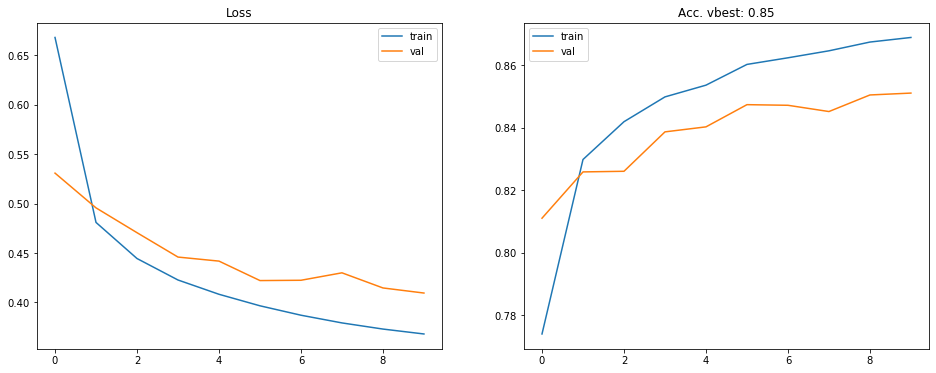

In [24]:
%%time
history = training_loop(10, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        history,
                        lr_scheduler)
plot_history(history)

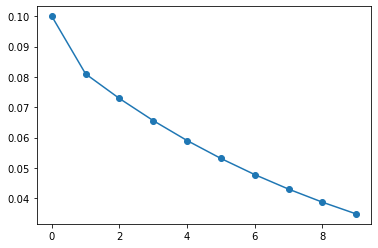

In [25]:
plt.plot(history['lr'], '-o')

## lr_scheduler & Adam

In [26]:
data_loader = get_data_loader(batch_size=128)

model = myNNModel(option=2).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.1  # the same as before at the beginning
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

history = None

Epoch 1, tloss 2.72 t_acc: 0.57  vloss 2.21  v_acc: 0.61
 >> best val accuracy updated: 0.6143 at epoch 1.
Epoch 2, tloss 2.56 t_acc: 0.59  vloss 2.40  v_acc: 0.50
Epoch 3, tloss 1.99 t_acc: 0.62  vloss 2.86  v_acc: 0.61
Epoch 4, tloss 1.97 t_acc: 0.62  vloss 1.81  v_acc: 0.63
 >> best val accuracy updated: 0.6348 at epoch 4.
Epoch 5, tloss 1.66 t_acc: 0.65  vloss 1.68  v_acc: 0.61
 >> best val accuracy updated: 0.7257 at epoch 6.
 >> best val accuracy updated: 0.7291 at epoch 7.
 >> best val accuracy updated: 0.7369 at epoch 8.
Epoch 10, tloss 0.94 t_acc: 0.73  vloss 1.03  v_acc: 0.75
 >> best val accuracy updated: 0.7529 at epoch 10.
finished training_loop().
Wall time: 1min 8s


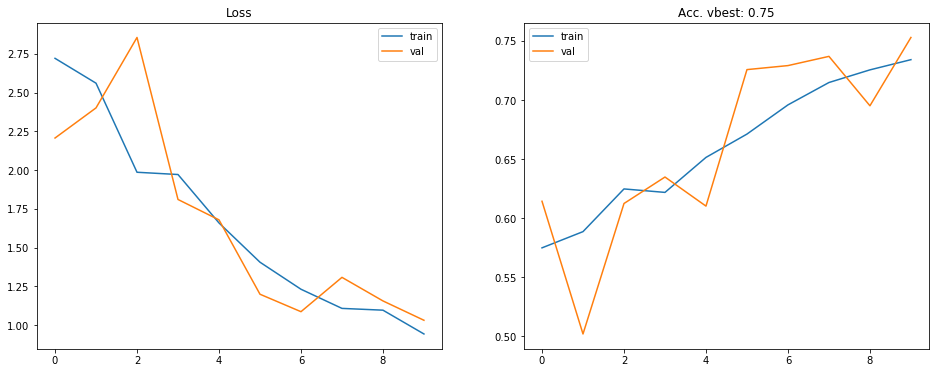

In [27]:
%%time
history = training_loop(10, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        history,
                        lr_scheduler)
plot_history(history)

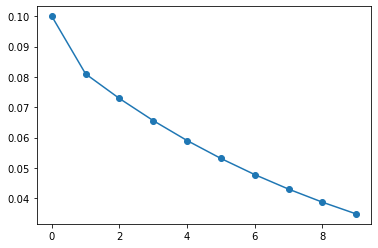

In [28]:
plt.plot(history['lr'], '-o')

---

## Practicum

- Try various attempts and report!

---

End.